In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import ExtraTreeRegressor,DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
X_train = pd.read_csv('/content/dengue_features_train.csv')
y = pd.read_csv('/content/dengue_labels_train.csv')['total_cases']
X_test = pd.read_csv('/content/dengue_features_test.csv')

In [ ]:
def kelvin_to_celsius(X):
  X['reanalysis_avg_temp_k'] = X['reanalysis_avg_temp_k'] - 272.15
  X['reanalysis_air_temp_k'] = X['reanalysis_air_temp_k'] - 272.15
  X['reanalysis_dew_point_temp_k'] = X['reanalysis_dew_point_temp_k'] - 272.15
  X['reanalysis_max_air_temp_k'] = X['reanalysis_max_air_temp_k'] - 272.15
  X['reanalysis_min_air_temp_k'] = X['reanalysis_min_air_temp_k'] - 272.15
  return X
def date_to_seasons(X):
  X['summer'] = 0
  X['fall'] = 0
  X['spring'] = 0
  X['winter'] = 0
  for i,date in enumerate(X['week_start_date']):
    month = datetime.datetime.strptime(date, "%Y-%m-%d").month
    if month >= 3 and month < 6:
      X['spring'][i] = 1
    elif month >= 6 and month < 9:
      X['summer'][i] = 1
    elif month>=9 and month <=11:
      X['fall'][i] = 1
    else:
      X['winter'][i] =1
  X = X.drop(columns = ['week_start_date'])
  return X
def normalize(X):
  for feature in X.keys():
    X[feature] = (X[feature] - np.min(X[feature])) / (np.max(X[feature]) - np.min(X[feature]))
  return X
def fill_na(df):
  for feature in df.keys():
    df[feature].fillna(method='ffill', inplace=True)
  return df
def arrange_categorical(X):
  X['sj'] = 0
  X['iq'] = 0 
  for i,city in enumerate(X['city']):
    if city == 'iq':
      X['iq'][i] = 1
    if city == 'sj':
      X['sj'][i] = 1
  X = X.drop(columns = ['city'])
  return X

In [ ]:
X_train = arrange_categorical(X_train)
X_train = date_to_seasons(X_train)
X_train = fill_na(X_train)
X_train = kelvin_to_celsius(X_train)
X_train = normalize(X_train)


X_test = arrange_categorical(X_test)
X_test = date_to_seasons(X_test)
X_test = fill_na(X_test)
X_test = kelvin_to_celsius(X_test)
X_test = normalize(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarn

In [ ]:
X_sj_train = X_train[:936].drop(columns=['iq','sj']).reset_index(drop=True)
y_sj_train = y[:936].reset_index(drop=True)
X_iq_train = X_train[936:].drop(columns=['iq','sj']).reset_index(drop=True)
y_iq_train = y[936:].reset_index(drop=True)
X_sj_test = X_test[:260].drop(columns=['iq','sj']).reset_index(drop=True)
X_iq_test = X_test[260:].drop(columns=['iq','sj']).reset_index(drop=True)
iq_split = 156/len(X_iq_train)
sj_split = 260/len(X_sj_train)
tahmini_feature_sj = y_sj_train[:260]
tahmini_feature_iq = y_iq_train[:156]

In [ ]:
def remove_most_corr(X):
  plt_iq, corr = pearson_corr(X)
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
  dropped_features= [column for column in upper.columns if any(upper[column] > 0.85)]

  X = X.drop(columns = dropped_features)

  return X
def pearson_corr(X_train):
  #Using Pearson Correlation
  plt.figure(figsize=(15,12))
  cor = X_train.corr()
  sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
  return plt,cor


def feature_select(X,y,feature_count):
  model = LinearRegression()
  #Initializing RFE model
  rfe = RFE(model, feature_count)
  #Transforming data using RFE
  X_rfe = rfe.fit_transform(X,y)  
  #Fitting the data to model
  model.fit(X_rfe,y)
  return rfe.support_


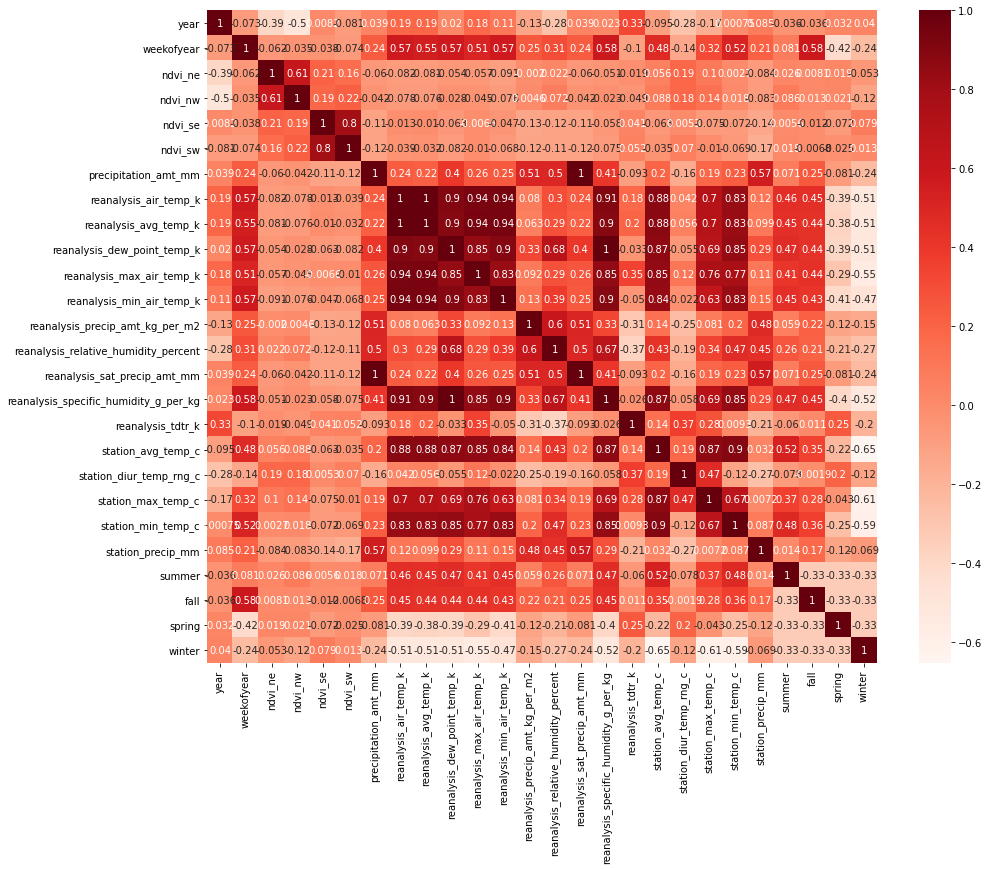

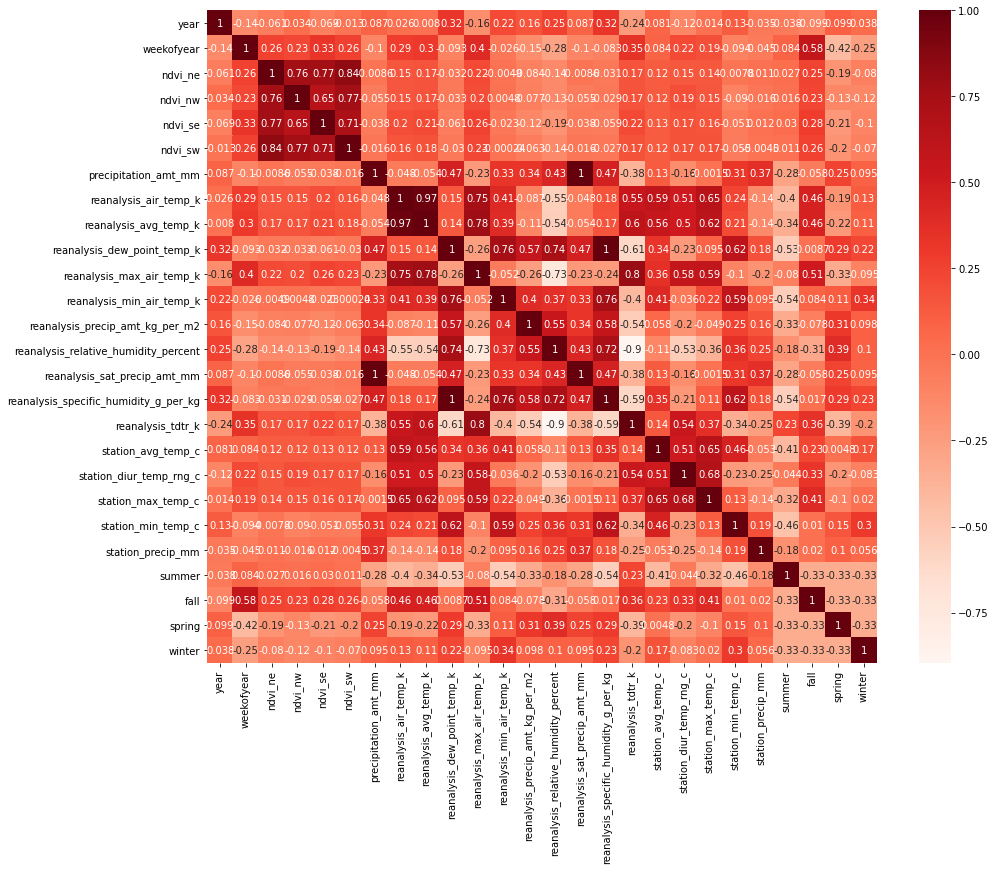

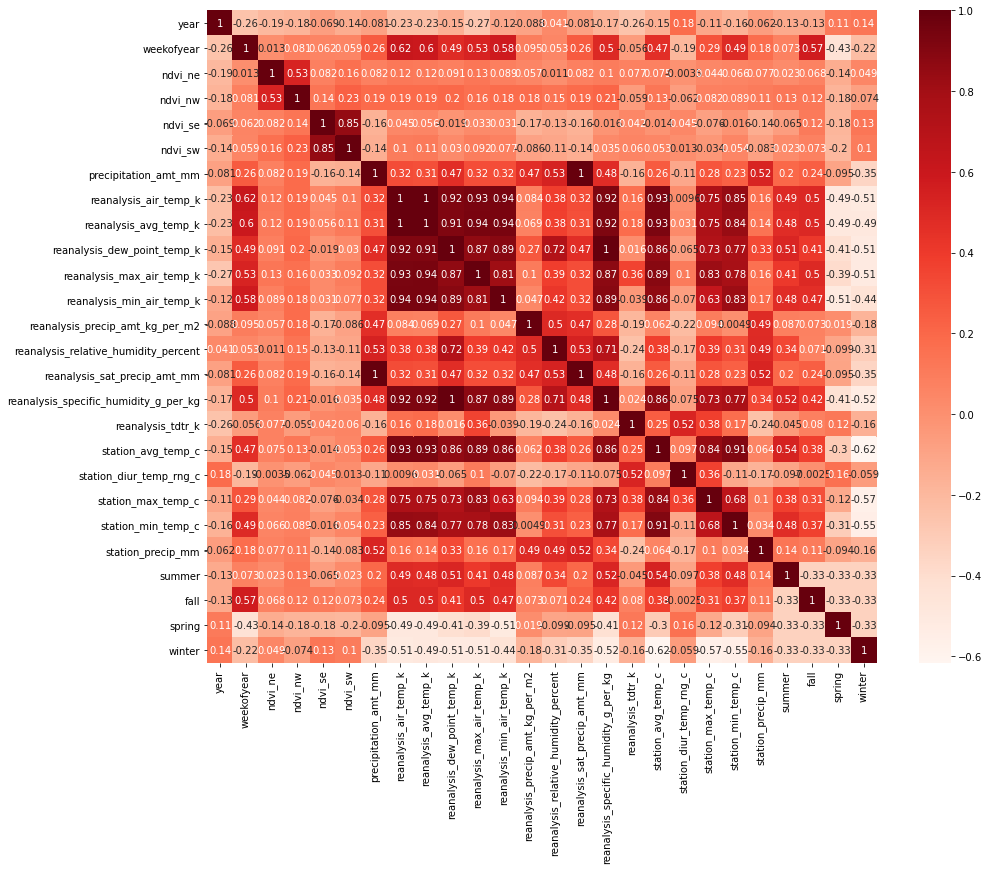

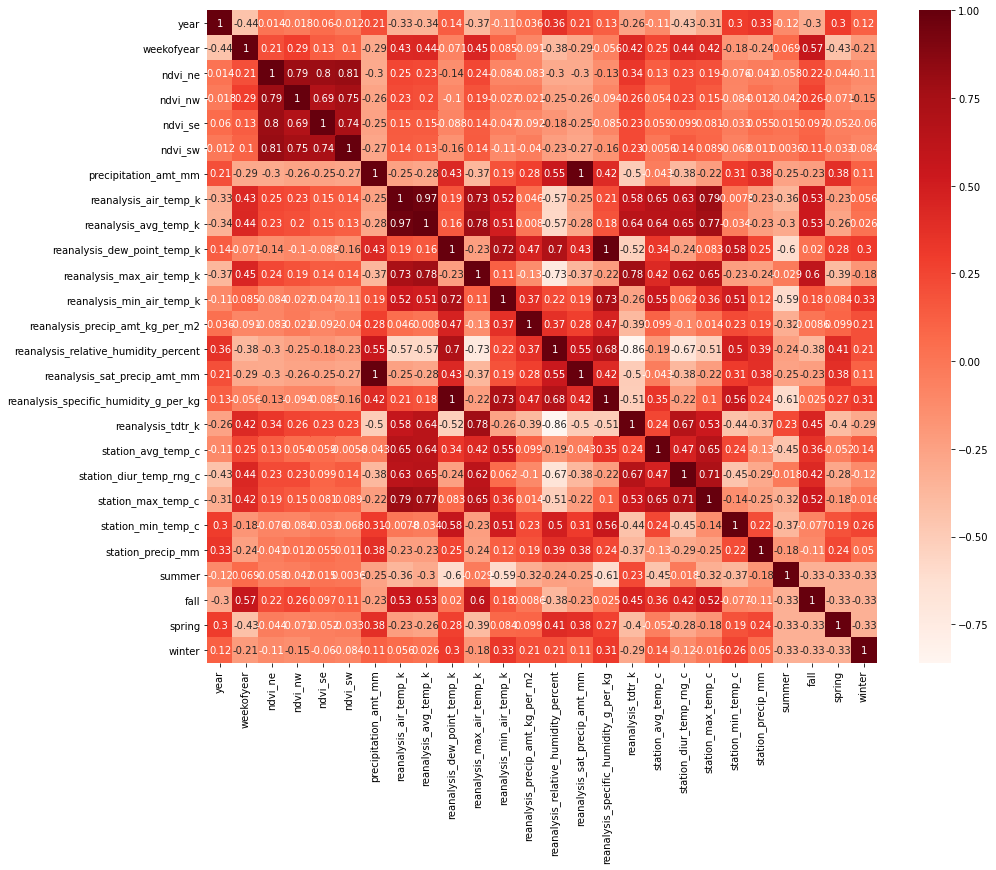

In [ ]:
X_sj_train = remove_most_corr(X_sj_train)
X_iq_train = remove_most_corr(X_iq_train)

X_sj_test = remove_most_corr(X_sj_test)
X_iq_test = remove_most_corr(X_iq_test)


In [ ]:
rfe_sj=feature_select(X_sj_train,y_sj_train,5)
rfe_iq=feature_select(X_iq_train,y_iq_train,5)

In [ ]:
deleted_features_iq = []
for i,feature in enumerate(X_iq_train.keys()):
  if rfe_iq[i] == False:
    deleted_features_iq.append(feature)

deleted_features_sj = []
for i,feature in enumerate(X_sj_train.keys()):
  if rfe_sj[i] == False:
    deleted_features_sj.append(feature)

In [ ]:
print(deleted_features_sj)
print(deleted_features_iq)

['weekofyear', 'ndvi_ne', 'ndvi_nw', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k', 'station_precip_mm', 'summer', 'fall', 'spring', 'winter']
['weekofyear', 'ndvi_nw', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm', 'fall', 'spring', 'winter']


In [ ]:

X_iq_train = X_iq_train.drop(columns = deleted_features_iq)
X_sj_train = X_sj_train.drop(columns = deleted_features_sj)

X_iq_test = X_iq_test.drop(columns = deleted_features_iq)
X_sj_test = X_sj_test.drop(columns = deleted_features_sj)

In [ ]:
print(X_sj_train.columns)
print(X_iq_train.columns)

Index(['year', 'ndvi_se', 'ndvi_sw', 'reanalysis_air_temp_k',
       'station_diur_temp_rng_c'],
      dtype='object')
Index(['year', 'ndvi_ne', 'ndvi_se', 'reanalysis_max_air_temp_k', 'summer'], dtype='object')


In [ ]:
def add_prev_day(X,y):
  X['prev_day'] = None
  X['prev_day'] = y.shift(1)
  X['prev_day'].fillna(method='bfill', inplace=True)
  return X
X_sj_train = add_prev_day(X_sj_train,y_sj_train)
X_iq_train = add_prev_day(X_iq_train,y_iq_train)

In [ ]:
X_sj_test['prev_day'] = None
X_sj_test['prev_day'] = tahmini_feature_sj

X_iq_test['prev_day'] = None
X_iq_test['prev_day'] = tahmini_feature_iq

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [ ]:
def ANN(X_train,y_train,split):
  model = Sequential()
  model.add(Dense(6, input_dim=len(X_train.keys()), activation='relu'))
  model.add(Dropout(0.8))
  model.add(Dense(1))
  model.compile(loss='mean_absolute_error', optimizer='adam')

  batch_size = 32

  earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='min')
  mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, verbose=1, epsilon=1e-4, mode='min')

  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=1000, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss],shuffle = False, validation_split=split)
  return model,history

In [ ]:
from keras import backend as K
model_iq,history_iq = ANN (X_iq_train,y_iq_train,iq_split)
K.set_value(model_iq.optimizer.learning_rate, 0.01)

model_sj,history_sj = ANN (X_sj_train,y_sj_train,sj_split)
K.set_value(model_sj.optimizer.learning_rate, 0.01)

Epoch 1/1000
12/12 [==============================] - 0s 10ms/step - loss: 8.7569 - val_loss: 11.7285
Epoch 2/1000
12/12 [==============================] - 0s 3ms/step - loss: 7.6378 - val_loss: 11.5097
Epoch 3/1000
12/12 [==============================] - 0s 3ms/step - loss: 8.2208 - val_loss: 11.2759
Epoch 4/1000
12/12 [==============================] - 0s 2ms/step - loss: 7.9679 - val_loss: 11.0378
Epoch 5/1000
12/12 [==============================] - 0s 3ms/step - loss: 7.4220 - val_loss: 10.7830
Epoch 6/1000
12/12 [==============================] - 0s 2ms/step - loss: 7.7575 - val_loss: 10.5322
Epoch 7/1000
12/12 [==============================] - 0s 3ms/step - loss: 7.5627 - val_loss: 10.3255
Epoch 8/1000
12/12 [==============================] - 0s 3ms/step - loss: 7.1427 - val_loss: 10.1587
Epoch 9/1000
12/12 [==============================] - 0s 2ms/step - loss: 6.7437 - val_loss: 9.9911
Epoch 10/1000
12/12 [==============================] - 0s 3ms/step - loss: 7.1893 - val_los

In [ ]:
X_iq_test = X_iq_test.drop(columns = deleted_features_iq)
X_sj_test = X_sj_test.drop(columns = deleted_features_sj)

In [ ]:
X_iq_test.drop(del)

In [ ]:
tahmini_feature_sj = y_sj_train[:260]
tahmini_feature_iq = y_iq_train[:156]
X_sj_test['prev_day'] = None
X_sj_test['prev_day'] = tahmini_feature_sj

X_iq_test['prev_day'] = None
X_iq_test['prev_day'] = tahmini_feature_iq

In [ ]:
pred_sj = model_sj.predict(X_sj_test)
pred_sj = pred_sj.astype(int)

prediction_sj = []
for p in pred_sj:
  prediction_sj.append(int(p))

pred_iq = model_iq.predict(X_iq_test)
pred_iq = pred_iq.astype(int)

prediction_iq = []
for p in pred_iq:
  prediction_iq.append(int(p))

In [ ]:
def write_csv(predicton):
  temp = pd.read_csv('/content/dengue_features_test.csv')
  submission_df = temp[['year','weekofyear']]
  submission_df['city'] = None
  for i,sample in enumerate(temp['city']):
    if sample == 'sj':
      submission_df.loc[i, 'city'] = 'sj'
    else:
      submission_df.loc[i, 'city'] = 'iq'
      
  submission_df = submission_df[['city','year','weekofyear']]
  submission_df = pd.concat([submission_df, pd.DataFrame({'total_cases': prediction})], axis=1, join='inner')
  submission_df.to_csv(r'submission.csv', index = False)

  return submission_df

In [ ]:
prediction = prediction_sj + prediction_iq
submission_df = write_csv(prediction)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
submission_df

,city,year,weekofyear,total_cases
0,sj,2008,18,8
1,sj,2008,19,8
2,sj,2008,20,8
3,sj,2008,21,8
4,sj,2008,22,8
...,...,...,...,...
411,iq,2013,22,1
412,iq,2013,23,2
413,iq,2013,24,2
414,iq,2013,25,2
